<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/CNN_classifier_on_remote_sensing_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet classifier for landcover classification from remote sensing images

In this tasks, we will again use the same portion of the [SAT-6](https://csc.lsu.edu/~saikat/deepsat/) dataset from Louisiana State University and NASA Ames Research Center.

In this notebook, we will make use of ResNet on the same subset of SAT-6 dataset.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm

## Obtaining the data
The data is available via this B2share link [link](https://b2share.eudat.eu/records/89654eac10724d30a6c7e51f2c5422de). Download all the files at the same folder path where you are creating this notebook

Alternatively use the following wget commands to download the data

The following cell can be executed in Google colab

In [ ]:
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/X_test_sat6.csv
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/y_test_sat6.csv
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/sat6annotations.csv

--2025-06-01 13:15:37--  https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/X_test_sat6.csv
Resolving b2share.eudat.eu (b2share.eudat.eu)... 86.50.166.97
Connecting to b2share.eudat.eu (b2share.eudat.eu)|86.50.166.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 905628829 (864M) [text/plain]
Saving to: ‘X_test_sat6.csv’

X_test_sat6.csv     100%[===================>] 863.67M  24.9MB/s    in 35s     

2025-06-01 13:16:13 (24.7 MB/s) - ‘X_test_sat6.csv’ saved [905628829/905628829]

--2025-06-01 13:16:13--  https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/y_test_sat6.csv
Resolving b2share.eudat.eu (b2share.eudat.eu)... 86.50.166.97
Connecting to b2share.eudat.eu (b2share.eudat.eu)|86.50.166.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 972000 (949K) [text/plain]
Saving to: ‘y_test_sat6.csv’

y_test_sat6.csv     100%[===================>] 949.22K  1.49MB/s    in 0.6s    

2025-06-01 13:16

In [ ]:
# load the csv file with the image data. Each row belongs to one sample. Each sample has 3136 columns i.e. 4 channels (R,G,B, and NIR) and 28 \times 28 spatial size
landcover_df = pd.read_csv("./X_test_sat6.csv",header=None)
landcover_df

,0,1,2,3,4,5,6,7,8,9,...,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135
0,95,91,61,157,105,113,101,179,50,35,...,107,181,118,137,127,205,90,105,86,183
1,102,102,103,137,108,110,116,154,88,83,...,91,157,95,92,84,143,89,85,76,130
2,47,54,95,10,79,89,108,15,96,131,...,118,17,82,98,125,18,61,69,113,13
3,200,181,178,218,192,177,176,214,162,141,...,139,203,157,138,125,193,147,128,107,187
4,85,101,100,15,87,102,97,16,54,71,...,74,8,37,49,76,6,27,43,69,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80995,82,82,115,17,104,123,131,23,100,119,...,146,32,137,152,159,44,159,166,166,61
80996,170,148,147,174,203,188,163,190,211,197,...,134,172,163,154,136,175,172,157,143,177
80997,140,136,126,190,156,163,152,208,152,170,...,126,162,93,111,119,170,68,66,61,123
80998,89,87,99,13,64,66,89,9,16,26,...,111,15,49,52,97,11,47,56,102,9


# Read annotation labels from different csv file

In [ ]:
# Read the annotation file to get the annotation i.e. classname corresponding to the labels
annotations = pd.read_csv("./sat6annotations.csv", header=None)
print(annotations)
labels = annotations[0].values
print(f'class labels: {labels}')

             0  1  2  3  4  5  6
0     building  1  0  0  0  0  0
1  barren_land  0  1  0  0  0  0
2        trees  0  0  1  0  0  0
3    grassland  0  0  0  1  0  0
4         road  0  0  0  0  1  0
5        water  0  0  0  0  0  1
class labels: ['building' 'barren_land' 'trees' 'grassland' 'road' 'water']


**Reminder :**  The data structure that you see above is called _one-hot encoding_


In [ ]:
# load the csv file with the labels of all samples
labels_df = pd.read_csv("./y_test_sat6.csv",header=None)
print(labels_df)
# get the names of the class labels (here, only "0" to "5")
# These correspond to the labels printed above
column_names = labels_df.columns.values

       0  1  2  3  4  5
0      0  0  1  0  0  0
1      0  0  1  0  0  0
2      0  0  0  0  0  1
3      0  1  0  0  0  0
4      0  0  0  0  0  1
...   .. .. .. .. .. ..
80995  0  0  0  0  0  1
80996  0  1  0  0  0  0
80997  0  0  1  0  0  0
80998  0  0  0  0  0  1
80999  0  0  1  0  0  0

[81000 rows x 6 columns]


# Plot random samples for illustration

&#x1F479; _Task:_ Plot few samples to see visually the data and gain more insights on how to reshape the 1d data to a 4 channel image (RGB & NIR)

6


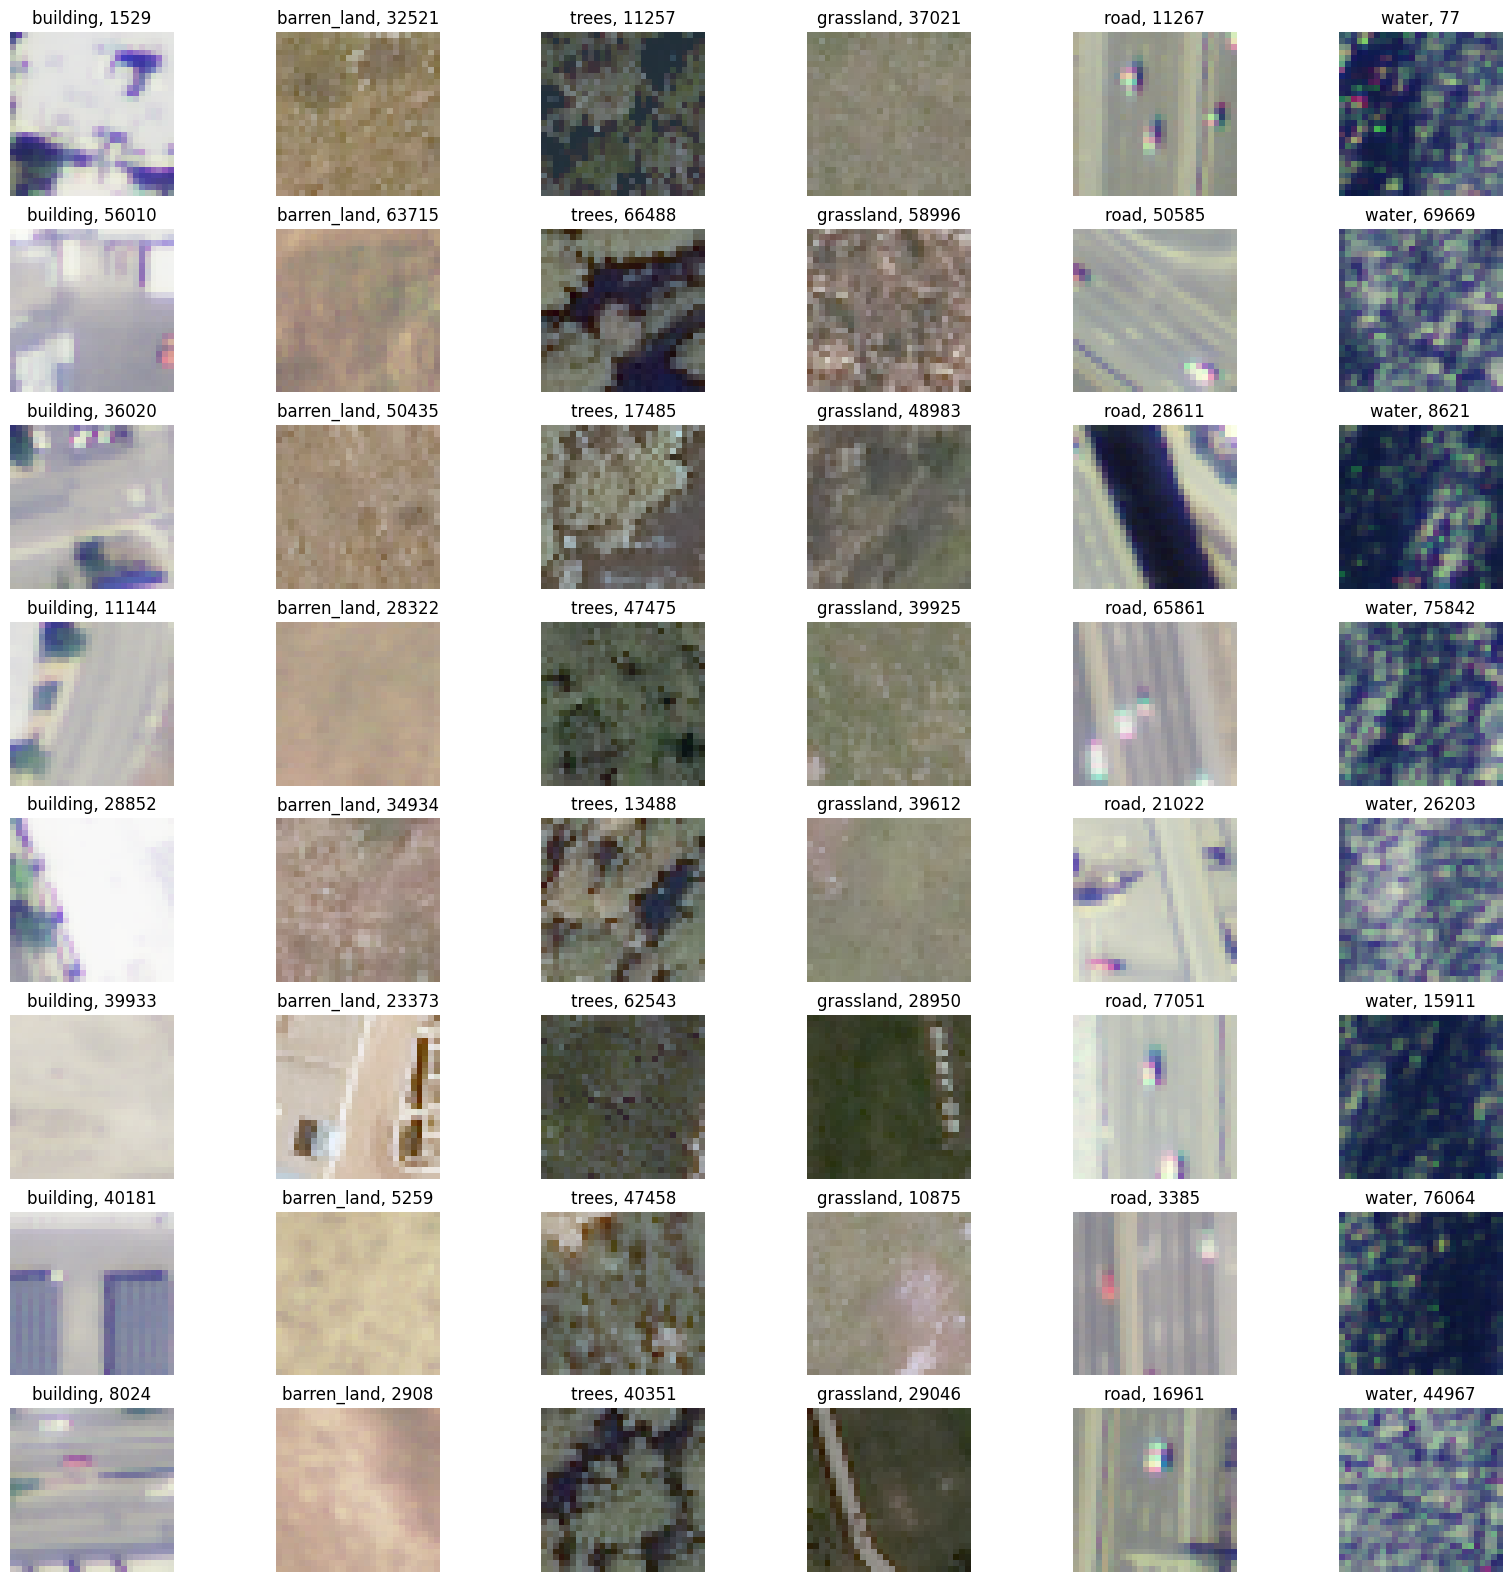

In [ ]:
num_classes = len(column_names)
print(num_classes)
num_samples = 8  # number of rows to plot
sample_idx = []
for column in column_names:
    # find all indices of a given class
    class_idx = labels_df[column] == 1
    # randomly select num_samples from this index list - make sure to avoid duplicates
    sample_idx.append(np.random.choice(np.where(class_idx.values)[0], size=num_samples, replace=False).tolist())

fig, ax = plt.subplots(num_samples, num_classes, figsize=(20,20))
for i in range(num_samples):
    for j in range(num_classes):
        data_index = sample_idx[j][i]
        ax[i,j].set_title(f"{labels[j]}, {data_index}")
        ax[i,j].axis('off')
        data = np.reshape(landcover_df.iloc[data_index].values,(-1,28,28,4))
        ax[i,j].imshow(data[0,...,:3])

### Create the training and test datasets

The dataset is not balanced. Use ***num_train*** and ***num_test*** as a definite integer number.

Note: the maximum we tried is ***num_train*** = 2000 and ***num_test*** = 200. Beyond that for some classes, we did not find that many samples

In case you want all samples for training then use ***num_train*** = -1

In [ ]:
num_train = 1000 #replace with -1 if all samples need to be used for training
num_test = 100
train_idx = []
test_idx = []
for column in column_names:
    # find all indices of a given class
    class_idx = labels_df[column] == 1
    # randomly select num_train and num_test values from this index list - make sure to avoid duplicates
    valid_indices = np.where(class_idx.values)[0]
    random_indices = np.random.permutation(valid_indices)
    test_idx.extend(random_indices[:num_test])
    train_idx.extend(random_indices[num_test:num_test+num_train if num_train != -1 else num_train])
print(f'number of train indices: {len(train_idx)}, number of test indices: {len(test_idx)}')


number of train indices: 6000, number of test indices: 600


In [ ]:
# Extract images and labels corresponding to the selected indices
train_X = landcover_df.iloc[train_idx]
train_y = labels_df.iloc[train_idx]
test_X = landcover_df.iloc[test_idx]
test_y = labels_df.iloc[test_idx]

# Calculate Normalization Parameter using Train Dataset

In [ ]:
train_X_reshape = train_X.values.reshape((-1,28,28,4))
mean_per_channels = np.mean(train_X_reshape,axis=(0,1,2)).astype(np.float32)
std_per_channels = np.std(train_X_reshape,axis=(0,1,2)).astype(np.float32)
mean_per_channels, std_per_channels

(array([132.46544, 132.54372, 129.66632, 120.99534], dtype=float32),
 array([56.017036, 51.540497, 47.423973, 65.815346], dtype=float32))

## Define torch dataset

From here, we will make use of general workflow of PyTorch. First thing is to create a dataset. We are making use of mapped-style dataset. [Refer this page for more details](https://pytorch.org/docs/stable/data.html#map-style-datasets)

Important thing is to define the total length under dunder function *__len__* and data corresponding to the index under *__getitem__*

In [ ]:
class SAT6Dataset(Dataset):
  def __init__(self,data_df,label_df, normalization_parameter):
    super(SAT6Dataset,self).__init__()
    self.data_df = data_df
    self.label_df = label_df
    self.normalization = normalization_parameter

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self,idx):
    data = self.data_df.iloc[idx].values.reshape((28,28,4)).astype(np.float32)
    data = (data-self.normalization[0])/self.normalization[1]
    #data = data/255.0
    data = np.transpose(data,axes=(2,0,1))
    label = self.label_df.iloc[idx].values
    label_args = np.where(label==1)[0]

    return (data,label_args[0])

In [ ]:
# define two dataset one for train and other for test
sat6_train_dataset = SAT6Dataset(train_X,train_y,(mean_per_channels,std_per_channels))
sat6_test_dataset = SAT6Dataset(test_X,test_y,(mean_per_channels,std_per_channels))

Now we utilize a pre-defined ResNet model from PyTorch's torchvision.models.  For a lightweight model suitable for training on limited resources, consider using ResNet18.




In [ ]:
import torchvision.models as models
import torch.nn as nn

# use the model of torchvision
resnet18 = models.resnet18(pretrained=False)

# modify the first convolutional layer to accept 4 channels instead of 3
resnet18.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Define the device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

Define training parameters


*   Optimizer : This reulates the rate of learning. USe wither adam or SGD. For other optimizers, feel free to add them.
*   Scheduler : It updates the learning rate during the training process. We have commented here out. PLease feel free to play with it.
*   Loss function: As it is a multi-class classification problem, CrossEntropy is a suitable loss function.



In [ ]:
optim = "adam"
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001) if optim == "adam" else torch.optim.SGD(resnet18.parameters(), lr=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

Previously, we have defined dataset which takes an index as a parameter and provides data corresponding to the index. In such deep learning problems, we process them in a batch. DataLoader takes control of such requirements by defining the paraemter such as **batch_size** and **shuffle**.

**Note:**


*   In training, we want each time to have different samples in a batch. The ***shuffle*=True** ensures that. For validation, we do not required such shuffling, hence it is set to False
*   We used the whole length of test dataset as it is small. Incase of any issue with large number of test samples, feel free to decrease the number such as $256$



In [ ]:
train_dataloader = DataLoader(sat6_train_dataset,batch_size=256,shuffle=True,drop_last=True)
test_dataloader = DataLoader(sat6_test_dataset,len(sat6_test_dataset), shuffle=False)

# Training Routine
Define number of epochs for the training.


In [ ]:
num_epochs = 10
training_loss_per_epoch = []
validation_loss_per_epoch = []
acc_per_epoch = []

with tqdm(total=num_epochs) as pbar:
  for i in range(num_epochs):
    resnet18.train()
    for train_data_idx, train_data in enumerate(train_dataloader):
      optimizer.zero_grad()
      data, labels = train_data
      data = data.to(device)
      labels = labels.to(device)
      preds = resnet18(data)
      train_loss = loss_fn(preds,labels)
      train_loss.backward()
      optimizer.step()
    # uncomment incase scheduler is defined above
    #scheduler.step()
    training_loss_per_epoch.append(train_loss.item())

    resnet18.eval()
    pred_labels = []
    true_labels = []
    all_probs = []
    with torch.no_grad():
      for test_data_idx, test_data in enumerate(test_dataloader):
        data, labels = test_data
        data = data.to(device)
        labels = labels.to(device)
        preds = resnet18(data)
        probs = torch.softmax(preds, dim=1)
        val_loss = loss_fn(preds,labels)
        pred_labels.extend(torch.argmax(preds,dim=1).to('cpu'))
        true_labels.extend(torch.squeeze(labels).to('cpu'))
        all_probs.extend(probs.cpu().numpy())
    validation_loss_per_epoch.append(val_loss.item())
    acc = accuracy_score(true_labels,pred_labels)
    acc_per_epoch.append(acc)
    pbar.set_description(f"Epoch {i+1}/{num_epochs}: training_loss : {train_loss}, validation_loss : {val_loss} and accuracy : {acc} ")



Epoch 10/10: training_loss : 0.03543567284941673, validation_loss : 0.07818983495235443 and accuracy : 0.9816666666666667 :   0%|          | 0/10 [16:11<?, ?it/s]


The variables **training_loss_per_epoch**, **validation_loss_per_epoch**, and **acc_per_epoch** contains metrics after each epoch. Feel free to plot them to see how was the progress during training.

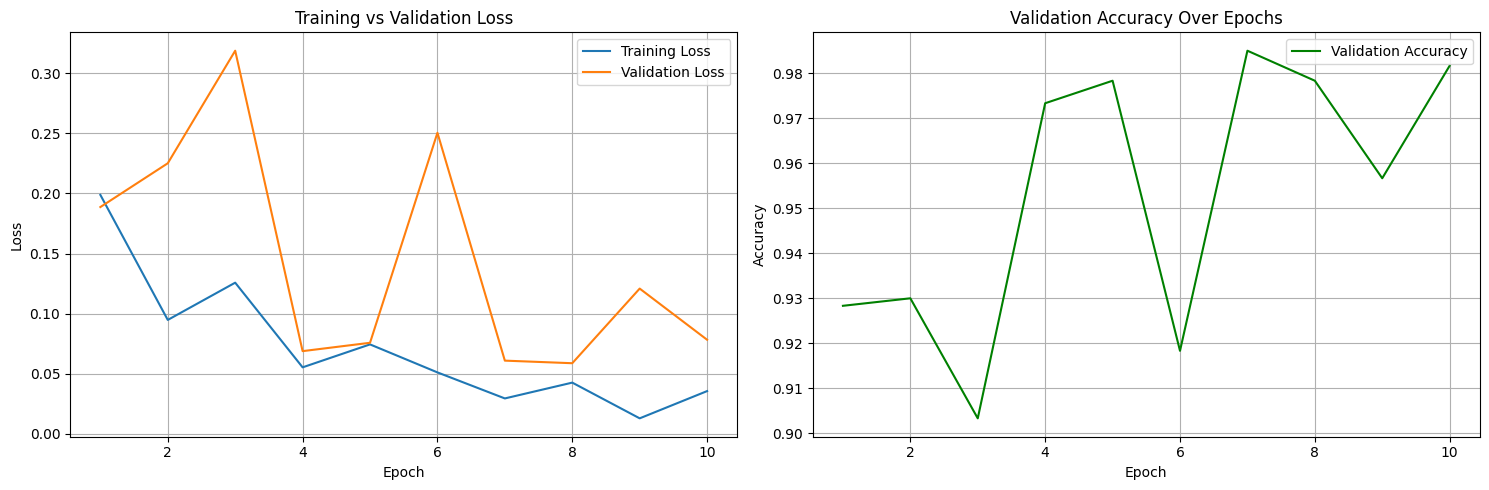

In [51]:
# Write plot routine
epochs = range(1, len(training_loss_per_epoch) + 1)

plt.figure(figsize=(15, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss_per_epoch, label='Training Loss')
plt.plot(epochs, validation_loss_per_epoch, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_per_epoch, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Evaluation

## Kappa statistics

In [52]:
from sklearn.metrics import cohen_kappa_score

# use predicted and actual values for calculating the kappa statistic
kappa = cohen_kappa_score(true_labels, pred_labels)
print(f"Kappa statistics: {kappa:.4f}")

Kappa statistics: 0.9780


The Kappa statistic of 0.978 indicats an almost perfect agreement between the predicted and actual class labels. So the prediction of the model is really good.  In addition we also plot a confusion matrix to specify this.

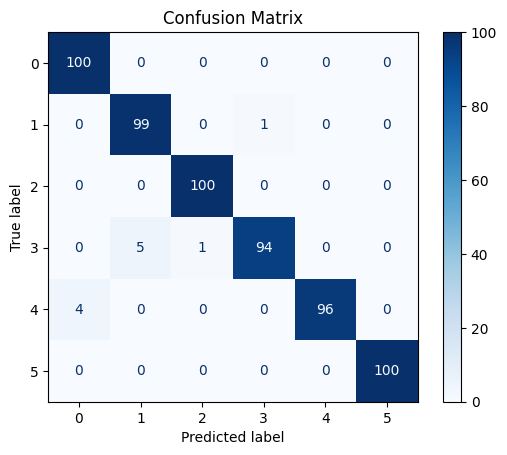

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

The confusion matrix shows that the model performs very well across all classes, with most predictions lying along the diagonal which means correct classifications. The low off-diagonal values suggest minimal misclassification.

## ROC Curve

Since we have a multiclass problem we first create a ROC curve for each class and plot it.

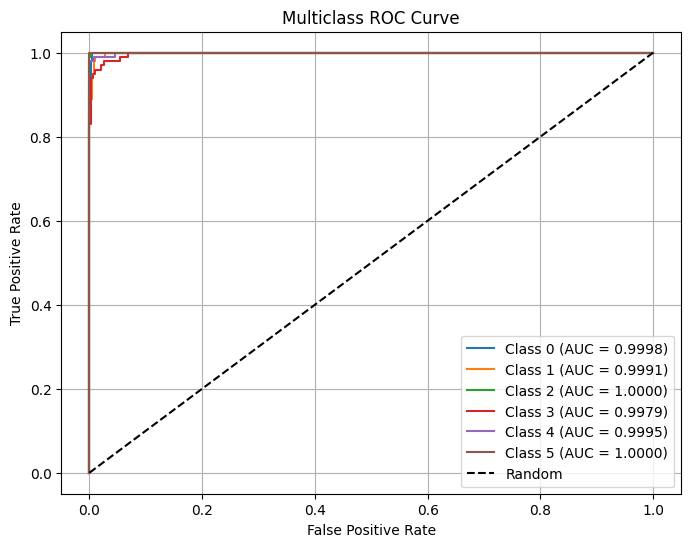

In [54]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# convert lists to NumPy arrays
true_labels = np.array(true_labels)
all_probs = np.array(all_probs)

# binarize true labels
n_classes = all_probs.shape[1]
y_true_bin = label_binarize(true_labels, classes=list(range(n_classes)))

# compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend()
plt.grid(True)
plt.show()




Since the AUC values are all very close to 1, it shows that the classifier performs very well. You can also see this from the curves because all of them are near the top-left corner, which means high true positives and low false positives. These results also underline the results of the kappa statistics, which were also very good.

In addition we plot an micro-average ROC curve which averages the ROC curves of the individual classes into one ROC curve.

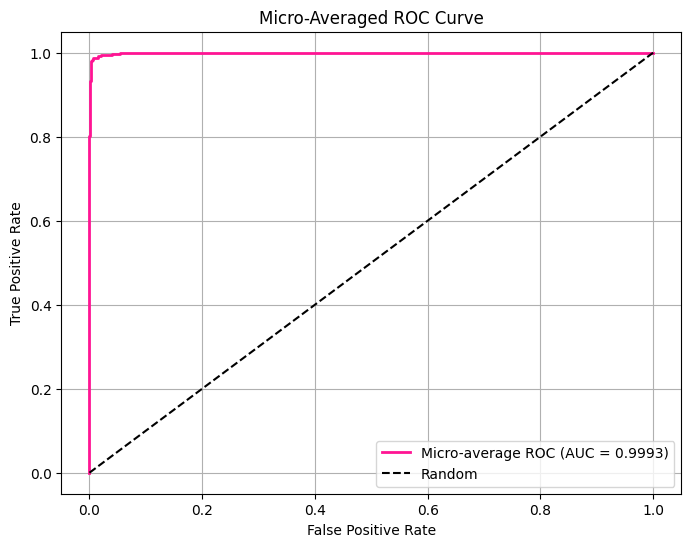

In [55]:
# compute micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plot the calculated ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"], color='deeppink',
         label=f"Micro-average ROC (AUC = {roc_auc['micro']:.4f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-Averaged ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


The micro-averaged ROC curve summerizes over all classes. With an AUC very close to zero, it shows a very good performance of the model. Since it averages the performance, this curve reflect the overall performance of the classifier very well.